# Forecasting Time Series: A Practical Walkthrough

Forecasting is a crucial tool for informed business decision-making, aiding in inventory management, budget planning, demand prediction, and more.
In this notebook, we'll demonstrate a practical, step-by-step approach to building time series forecasts, starting with simple models and progressively adding complexity to improve accuracy.

We’ll use **daily sales from a grocery chain in Ecuador** dataset which features rich patterns like trend, multiple seasonalities, and holiday effects (from Kaggle’s Store Sales competition).

---

## What We'll Cover

1. **Trend**: detecting long-term movements (using moving averages and linear regression) 
2. **Seasonality**: capturing repeating patterns (using indicators and Fourier features)
3. **Time-Series as Features**: modeling serial dependence (using lagged values and exogenous variables)
4. **Hybrid Models**: combining model strengths
5. **Predict future features**: using machine learning

Each part builds on the last to show how forecasts improve with each layer. Let’s get started.

---

# 1. Trend

The **trend** is the slow, long-term movement in a time series.  
It shows whether values are steadily increasing, decreasing, or staying flat over time.  
In retail sales, for example, a rising trend might reflect growing customer demand or market expansion.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/ZdS4ZoJ.png" width=800 alt="Trend examples">
<figcaption><center><i>Examples of trend in four different time series.</i></center></figcaption>
</figure>

In this notebook, we’ll focus on trends in the **mean** of the series. But trends can also show up in variation, volatility, or other aspects of the data.

We’ll look at trend in two ways:

1. Using a **moving average** to smooth daily sales  
2. Fitting a **linear regression** to forecast the long-term trend

---


### 1.1 Visualizing Trend with Moving Average

To highlight the trend and smooth out short-term noise, we use a **moving average**.

This involves averaging data points within a sliding window. Each point in the resulting plot is the average of neighboring values, revealing the underlying direction of the series.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/EZOXiPs.gif" width=800 alt="Moving average animation">
<figcaption><center><i>Moving average (red) over a noisy curve (blue), using a window of size 12.</i></center></figcaption>
</figure>

To see the true trend, our window size should be **longer than any seasonal cycle** in the data so that short-term effects don’t dominate the signal.

Let's see what it looks like with our **daily sales dataset**:

In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 1. Import the data
comp_dir = Path('Courses data')

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}

# Load the sales data with proper types and parse the date column
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    dtype=dtype,
    parse_dates=['date'],
)

# Set 'date' as the main index and add store and product family as sub-indexes
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)

# Calculate the average sales across all stores and families per day
average_sales = store_sales.groupby('date').mean()['sales']

In [42]:
# 2. Plot style
plot_params = {
    "figsize": (16, 5),
    "color": "black",
    "xlabel": "date",
    "markersize": 3,
    "marker": "o",
    "legend": False,
}

# Apply style separately
sns.set_style("whitegrid")

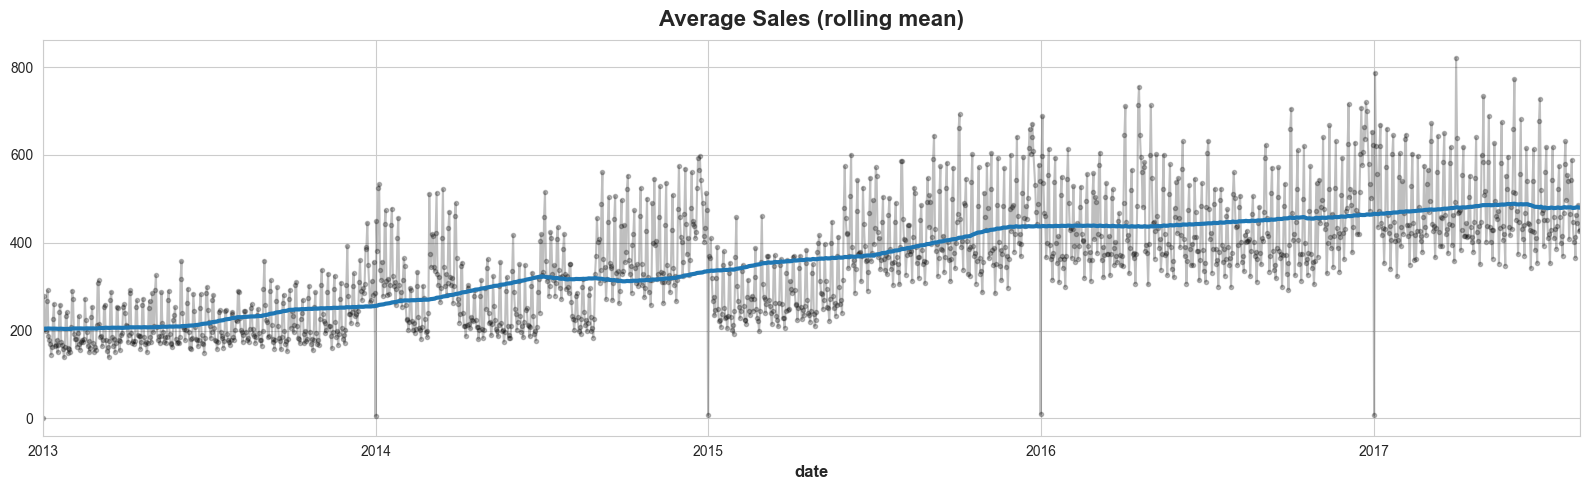

In [46]:

# Smooth the daily average sales with a centered 1-year rolling average
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

# Plot the average sales and the trend
ax = average_sales.plot(**plot_params, alpha=0.25, title="Average Sales (rolling mean)")
ax = trend.plot(ax=ax, linewidth=3);
ax;

We'll now use `DeterministicProcess` to create a feature set for a cubic trend model (a 3rd-degree polynomial) and generate a 90-day forecast.

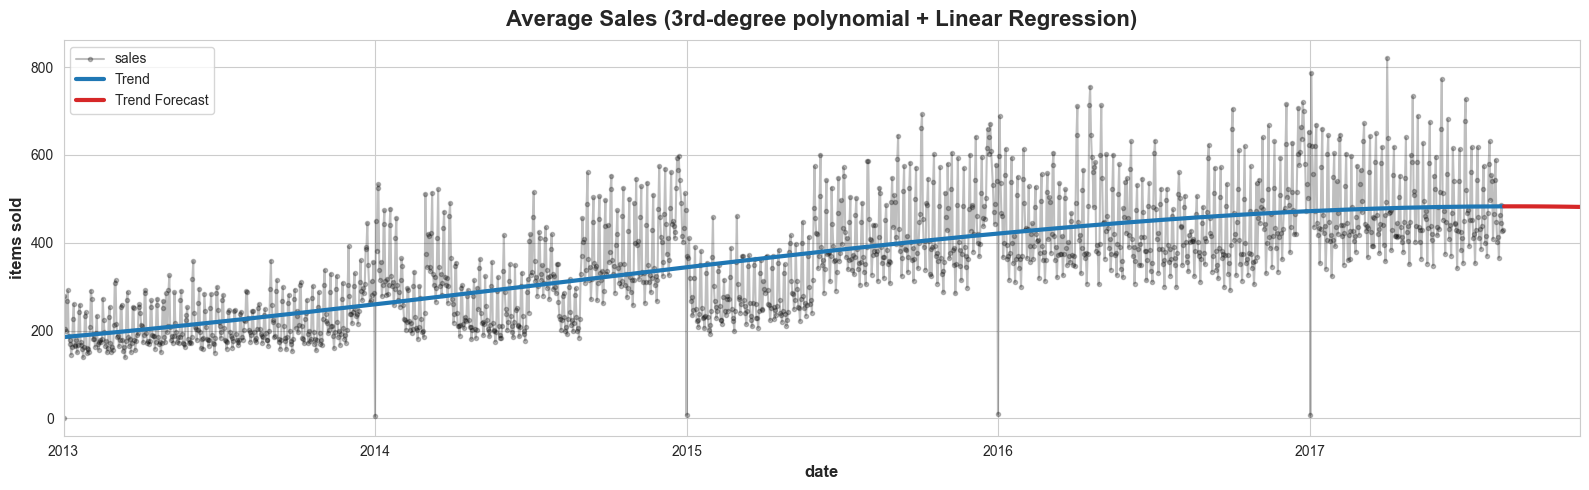

In [47]:
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

y = average_sales.copy()  # the target


dp = DeterministicProcess(
    index=y.index,
    order=3,
)
X = dp.in_sample()

# Create features for a 90-day forecast.
X_fore = dp.out_of_sample(steps=90)

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.25, title="Average Sales (3rd-degree polynomial + Linear Regression)", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

The linear model with a cubic trend captures the main upward movement and some curvature.<br>
For more complex trends, we could increase the polynomial order; however, high-order polynomials are generally poor for forecasting. Here's a demonstration:

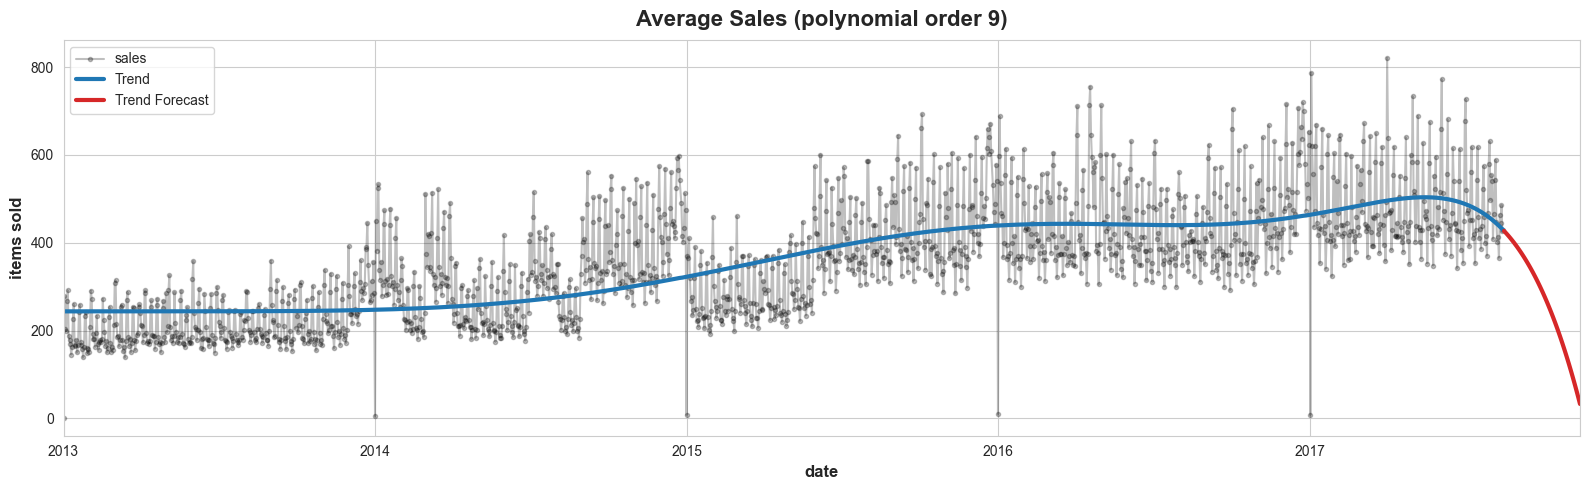

In [48]:
dp = DeterministicProcess(
    index=y.index,
    order=9,
)
X = dp.in_sample()

# Create features for a 90-day forecast.
X_fore = dp.out_of_sample(steps=90)

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.25, title="Average Sales (polynomial order 9)", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();


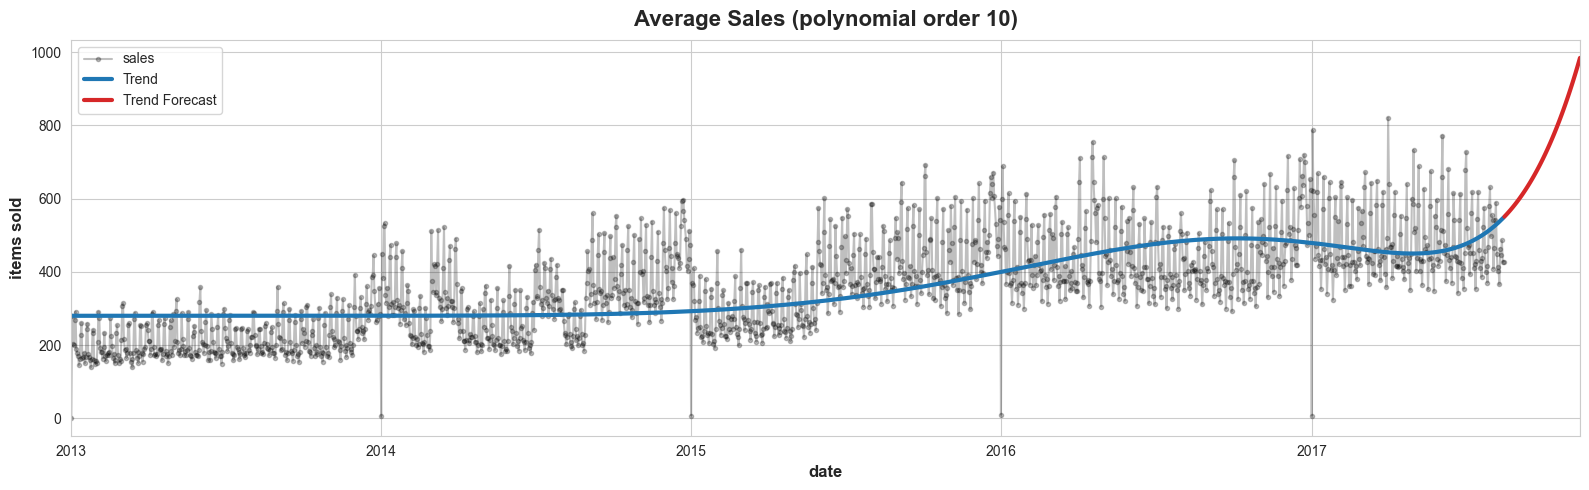

In [49]:
dp = DeterministicProcess(
    index=y.index,
    order=10,
)
X = dp.in_sample()

# Create features for a 90-day forecast.
X_fore = dp.out_of_sample(steps=90)

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.25, title="Average Sales (polynomial order 10)", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();


---

# 2. Seasonality

We say a series has **seasonality** when its mean shows regular periodic shifts (daily, weekly, yearly) driven by natural cycles or social conventions.

<figure style="padding:1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/ViYbSxS.png" width="800" alt="">
<figcaption style="text-align:center; font-style:italic;">
Seasonal patterns in four time series.
</figcaption>
</figure>

Two feature types model seasonality:

1. **Seasonal Indicators**: one‑hot encoding, for short,fixed periods (e.g. days of week)
2. **Fourier features**: for longer cycles (e.g. annual cycle)

Retail sales often exhibit strong weekly patterns (weekends vs weekdays) and annual patterns (holidays, seasons), which we'll explore next.

---

### 2.1 Seasonal Indicators

A **seasonal plot** overlays segments of the series on a common period. Example: daily Wikipedia views of “Trigonometry,” plotted by week, reveal higher weekday traffic and lower weekend traffic.

<figure style="padding:1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/bd7D4NJ.png" width="800" alt="">
<figcaption style="text-align:center; font-style:italic;">
Weekly seasonal pattern: weekdays vs. weekend.
</figcaption>
</figure>


One‑hot encode the period as categorical:

| Date       | Tue | Wed | Thu | Fri | Sat | Sun |
|------------|-----|-----|-----|-----|-----|-----|
| 2016‑01‑04 | 0   | 0   | 0   | 0   | 0   | 0   |
| 2016‑01‑05 | 1   | 0   | 0   | 0   | 0   | 0   |
| 2016‑01‑06 | 0   | 1   | 0   | 0   | 0   | 0   |
| …          | …   | …   | …   | …   | …   | …   |


Adding seasonal indicators lets models learn different means within a season:

<figure style="padding:1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/hIlF5j5.png" width="800" alt="">
<figcaption style="text-align:center; font-style:italic;">
Ordinary linear regression learns the mean at each time in the season.
</figcaption>
</figure>

Indicators act like on/off switches, only one is “on” at a time.  
Linear regression fits a baseline (e.g. 2379 for Mon) then adds the active indicator’s effect.

---

### 2.2 Fourier Features & the Periodogram

For long seasons, indicators become impractical. Instead we use **Fourier features** (sine and cosine pairs)to capture key frequencies.

<figure style="padding:1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/NJcaEdI.png" width="800" alt="">
<figcaption style="text-align:center; font-style:italic;">
Annual seasonality in the Wiki Trigonometry series.
</figcaption>
</figure>

Fourier pairs model frequencies (once‑per‑year, twice‑per‑year, …).

<figure style="padding:1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/bKOjdU7.png" width="600" alt="">
<figcaption style="text-align:center; font-style:italic;">
Top: once‑per‑year. Bottom: twice‑per‑year.
</figcaption>
</figure>

Adding a few pairs (e.g. four) approximates the seasonal curve with far fewer features than daily indicators.

<figure style="padding:1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/mijPhko.png" width="600" alt="">
<figcaption style="text-align:center; font-style:italic;">
Top: four Fourier pairs. Bottom: their sum approximates seasonality.
</figcaption>
</figure>


### Choosing pairs via the periodogram

The **periodogram** shows frequency strength:
  
<img src="https://storage.googleapis.com/kaggle-media/learn/images/PK6WEe3.png" width="600" alt=""> 

We see a drop after quarterly (4×/year), that's why whe chose four pairs for the annual season. We ignore the Weekly frequency since it's better modeled with indicators as we saw earlier.

---

### 2.3 Applying Seasonality to Retail Sales

In [50]:
# 1. Import the necessary libraries and data

from statsmodels.tsa.deterministic import CalendarFourier

holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool', 
    },
    parse_dates=['date'],
)
holidays_events = holidays_events.set_index('date').to_period('D')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

In [51]:
import matplotlib.pyplot as plt

def seasonal_plot(df, y, period, freq, 
                  figsize=(16,5), 
                  line_kw={'linewidth':2, 'alpha':0.6}):

    fig, ax = plt.subplots(figsize=figsize)
    for _, grp in df.groupby(period):
        grp = grp.sort_values(freq)
        ax.plot(grp[freq], grp[y], **line_kw)

    title = f"Seasonal Plot ({period}/{freq})"
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel(freq, fontweight='bold')
    ax.set_ylabel(y, fontweight='bold')
    return ax

In [52]:
from scipy.signal import periodogram

def plot_periodogram(series,
                     fs=1,
                     year_len=365,
                     ax=None,
                     figsize=(16, 6),
                     line_kw={'color':'purple','linewidth':1.5},
                     grid_kw={'color':'lightgray','linewidth':0.5,'linestyle':'-'}):

    # Compute spectrum
    f, Pxx = periodogram(series.values, fs=fs, scaling='spectrum')
    freq_yr = f * year_len

    # Seasonal ticks
    ticks = [1,2,4,6,12,26,52,104]
    labels = [
        "Annual (1)","Semiannual (2)","Quarterly (4)","Bimonthly (6)",
        "Monthly (12)","Biweekly (26)","Weekly (52)","Semiweekly (104)"
    ]

    if ax is None:
        sns.set_style("white")
        fig, ax = plt.subplots(figsize=figsize)

    # Clear and apply grid
    ax.grid(axis='y', **grid_kw)
    ax.xaxis.grid(True, **grid_kw)

    # Step-style plot
    ax.step(freq_yr, Pxx, where='mid', **line_kw)
    ax.set_xscale('log')

    # Format ticks
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=30, ha='right')
    ax.set_xlim(ticks[0]*0.8, ticks[-1]*1.2)

    # Y-axis label
    ax.set_ylabel("Variance", fontweight='bold', fontsize=10)
    ax.set_title("Periodogram", fontweight='bold', fontsize=20)
    return ax

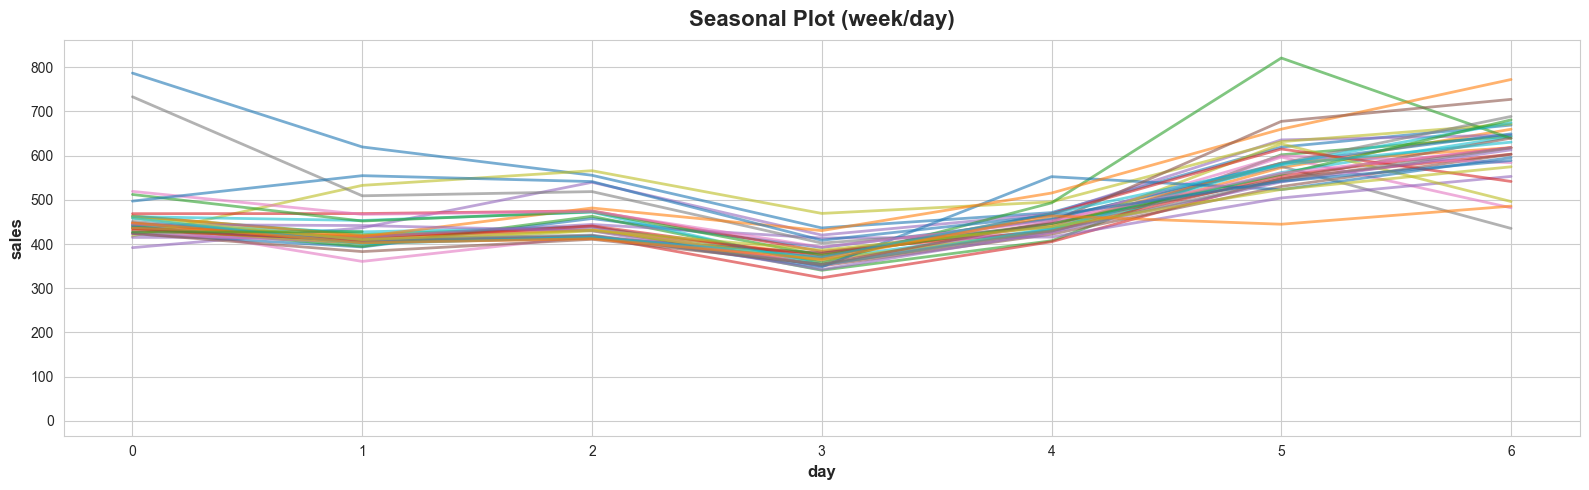

In [53]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

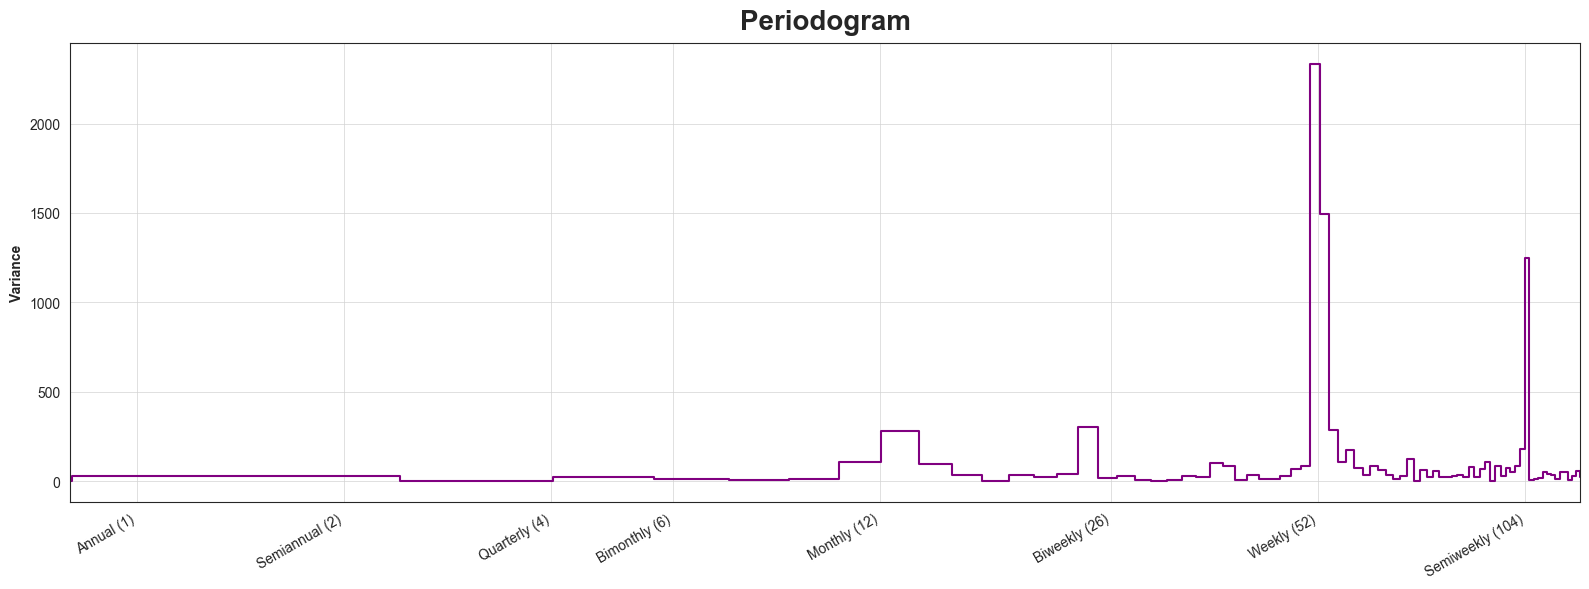

In [54]:
plot_periodogram(average_sales);

Both the seasonal plot and the periodogram suggest a strong weekly seasonality. From the periodogram, it appears there may be some monthly and biweekly components as well. In fact, the notes to the Store Sales dataset say wages in the public sector are paid out biweekly, on the 15th and last day of the month; a possible origin for these seasons.

-------------------------------------------------------------------------------

### 2.4 Create seasonal features

We will use `DeterministicProcess` and `CalendarFourier` to create:
- indicators for weekly seasons and
- Fourier features of order 4 for monthly seasons.

In [ ]:
y = average_sales.copy()

# Capture repeating monthly patterns using 4 sine/cosine pairs
fourier = CalendarFourier(freq='ME', order=4)  

dp = DeterministicProcess(
    index=y.index,
    constant=True,  # defines intercept
    order=1, # linear trend
    seasonal=True, # seasonal dummy variables
    additional_terms=[fourier],
    drop=True, # drop the constant and trend terms
)
X = dp.in_sample()

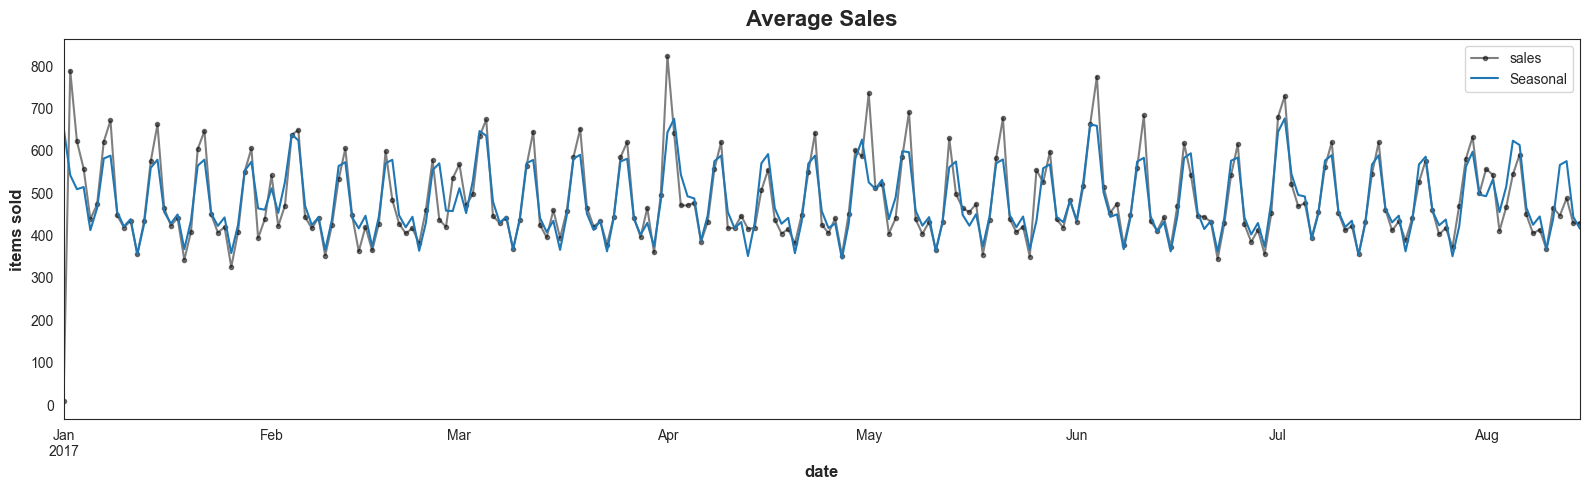

In [57]:
model = LinearRegression().fit(X, y)

# Align the index of the predicted values with the original data
y_pred = pd.Series( 
    model.predict(X), 
    index=X.index, 
    name='Fitted',
)

# Plot the original data and the fitted values
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

Now we can substract our predictions from the original series to check if we captured all seasonality:

Text(0.5, 1.0, 'Deseasonalized')

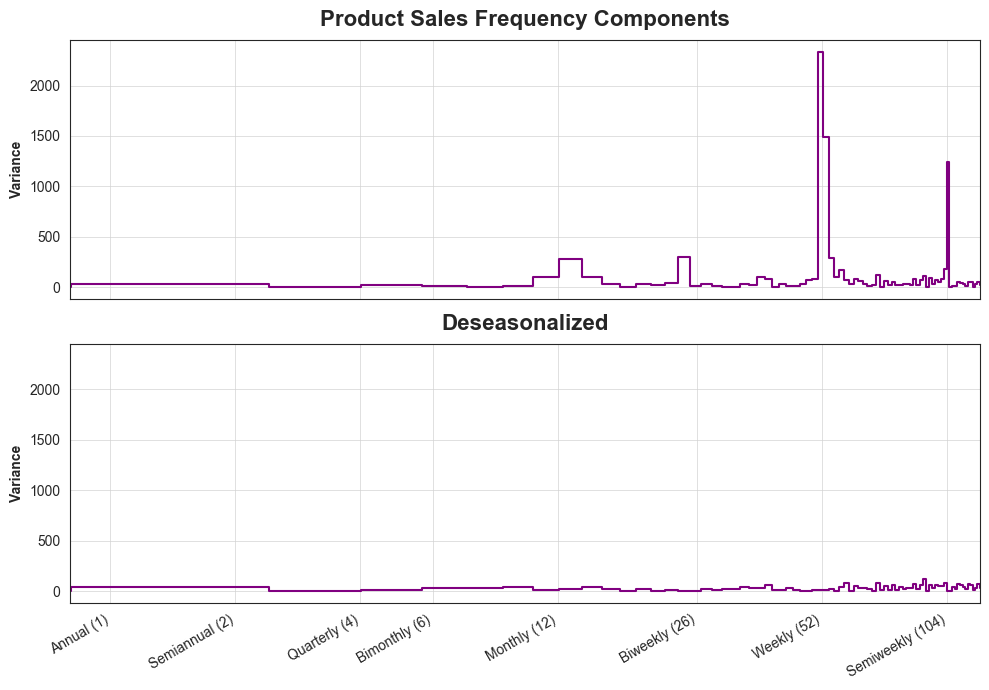

In [58]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1);
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized")

---

### 2.5 Check for remaining seasonality

Now that we captured the global seasonality, there is still work we can do to improve our predictive model.

The *Store Sales* dataset includes a table of Ecuadorian holidays.

In [59]:
# National and regional holidays in the training set
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


Let's highlight these **holidays** on our deseasonalized *Average Sales*, to check if they could have some predictive power:

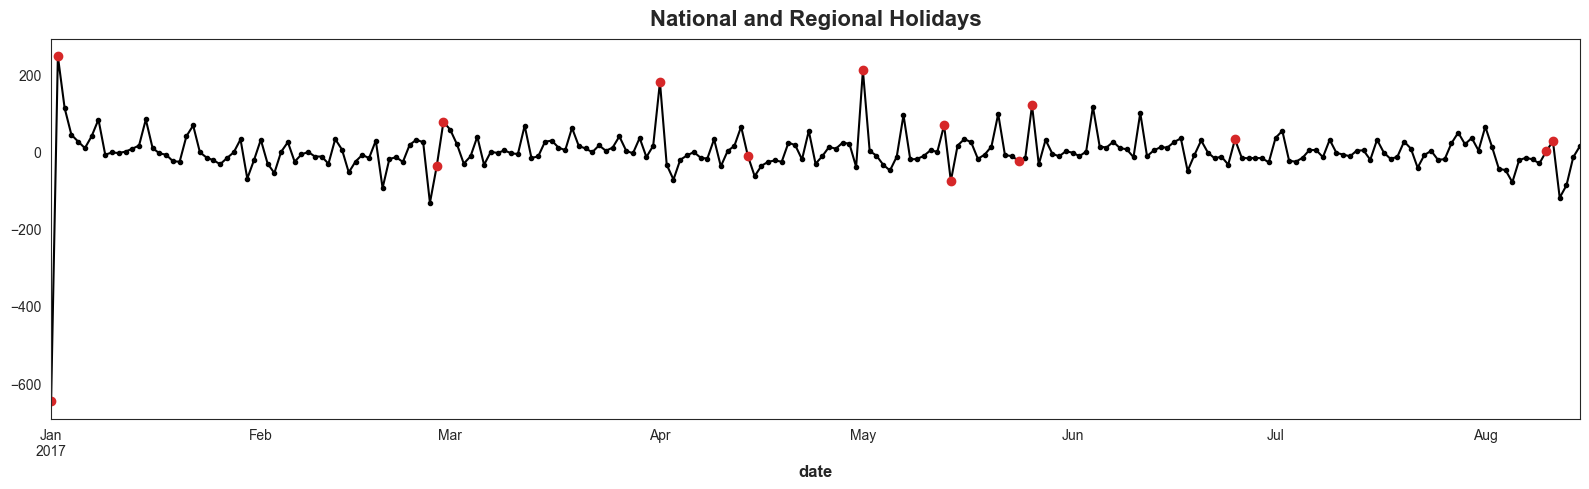

In [60]:
ax = y_deseason.plot(**plot_params) # plot deseasonalized data
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3') # plot holidays
ax.set_title('National and Regional Holidays')
sns.set_style("whitegrid")

Seems that we're on the right track. Let's add them to our model and see the result:

In [61]:
#  Create dummy variables for the holidays
X_holidays = pd.get_dummies(holidays)

X2 = X.join(X_holidays, on='date').fillna(0.0)

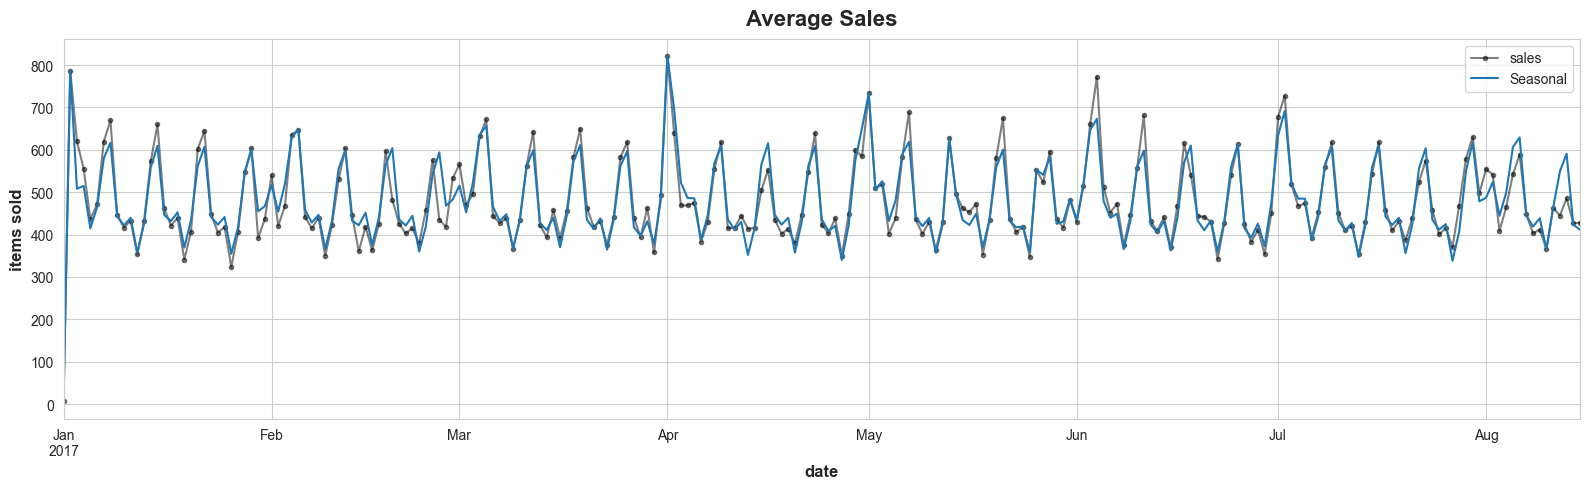

In [62]:
# Fit the model with the holidays
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

As expected, adding holidays to the model improved the fit.<br>
We can now apply this predictive approach individually to each product category and store:

In [ ]:
# Unstack store_nbr and family to create a multi-index DataFrame
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

# Create training data
fourier = CalendarFourier(freq='ME', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
# Add 
X['NewYear'] = (X.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [65]:
display(store_sales.index.get_level_values('family').unique())

CategoricalIndex(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
                  'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI',
                  'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II',
                  'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
                  'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR',
                  'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER',
                  'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES',
                  'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
                  'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
                 categories=['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', ..., 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'], ordered=False, dtype='category', name='family')

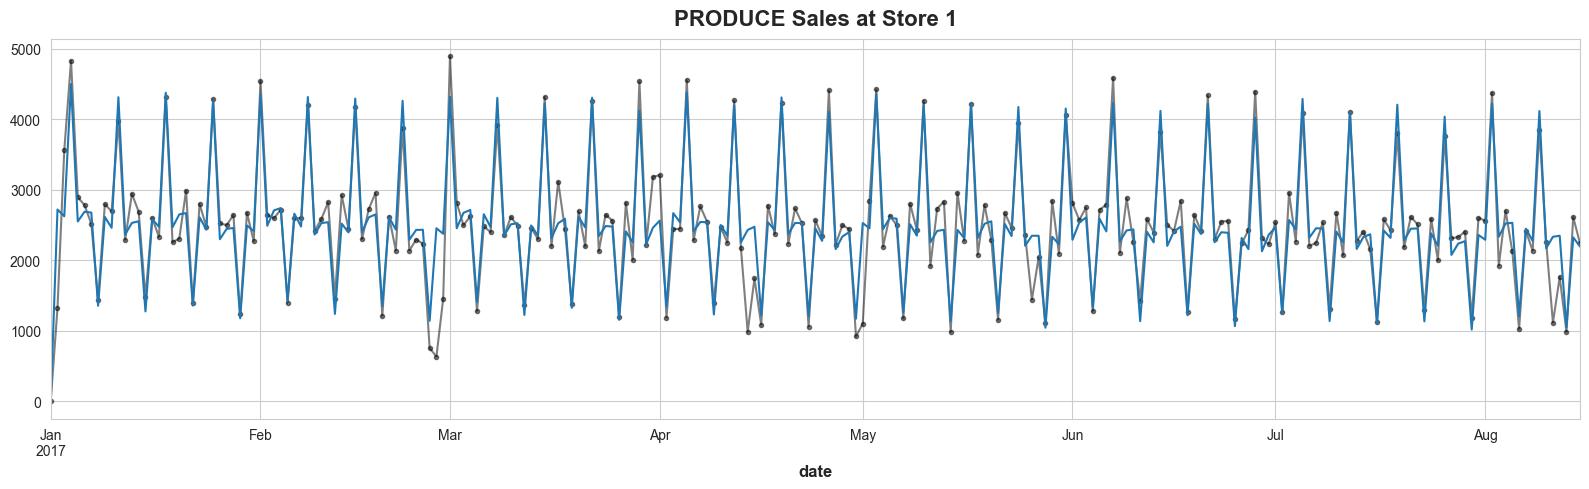

In [66]:
STORE_NBR = '1'
FAMILY = 'PRODUCE'

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params, alpha=0.5)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

---

# 3. Serial Dependence

While trend and seasonality capture patterns related to **time** itself, time series often depend on their own past values. This is known as **serial dependence**.

These patterns may not appear in a time plot but become clear when plotting the series against its past values:

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/X0sSnwp.png" width=800 alt="">
<figcaption style="text-align: center; font-style: italic">
Points on the right plot are <code>(value at time t‑1, value at time t)</code>. These series have serial dependence, not time dependence.
</figcaption>
</figure>


---

### 3.1 Cycles

A common type of serial dependence is a **cycle**:  
Patterns of rise and fall caused by how past values influence future ones, regardless of actual time steps.

Cyclic behavior is typical of systems with feedback or persistence (e.g. economies, epidemics, ecosystems, eruptions).

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/CC3TkAf.png" width=800 alt="">
<figcaption style="text-align: center; font-style: italic">
Four time series showing cyclic behavior.
</figcaption>
</figure>

Unlike seasonality (which is tied to specific times), cycles are driven by **recent events**, making them often irregular and less predictable.

---

### 3.2 Lagged Series & Lag Plots

To study serial dependence like cycles, we create **lagged series**: shifted versions of the target.

Lagging means shifting values **forward** in time, or shifting the time index **backward**.  
This makes past observations available as features for modeling.

#### Lag plots

A **lag plot** graphs `y(t)` vs. `y(t-k)`. Serial dependence appears as structure in the scatter.  
Example: US Unemployment shows a near‑linear relationship at lag 1.

<figure style="padding:1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/Hvrboya.png" width="600" alt="">
<figcaption style="text-align:center; font-style:italic;">
Lag plot of US Unemployment with autocorrelations.
</figcaption>
</figure>

- **Autocorrelation** at lag k = correlation between `y(t)` and `y(t-k)`.  
- US Unemployment: 0.99 at lag 1, 0.98 at lag 2, …


#### Choosing lags

- We don't want to include every lag with high autocorrelation (some carry redundant information).  
- **Partial autocorrelation** measures “new” correlation after accounting for earlier lags.  
- In US Unemployment, Partial Autocorrelation Function (PACF) shows lags 1-6 significant → choose lags 1-6.

<figure style="padding:1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/6nTe94E.png" width="600" alt="">
<figcaption style="text-align:center; font-style:italic;">
Partial autocorrelations (lags 1-12) with 95% “no‑correlation” intervals.
</figcaption>
</figure>

A PACF plot is called a **correlogram**, analogous to the periodogram for Fourier features.



#### Non‑linear dependence

Autocorrelation/PACF capture only linear dependence.  
We'll use lag plots or measures like mutual information to detect non‑linear structure.

<figure style="padding:1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/Q38UVOu.png" width="350" alt="">
<figcaption style="text-align:center; font-style:italic;">
Lag plot of the *Sunspots* series (non‑linear pattern).
</figcaption>
</figure>

Now let's apply lags to our Retail Sales

---

### 3.3 Applying Series Dependance to Retail Sales

In [127]:
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)

Sales of school & office supplies exhibit growth‑and‑decay patterns not captured by trend or seasonality. To model these pure **cycles**, we first remove seasonality. The next cell deseasonalizes the “Supply Sales” series and saves it as `y_deseason`, so that subsequent correlograms and lag‑feature models focus solely on cyclic behavior.

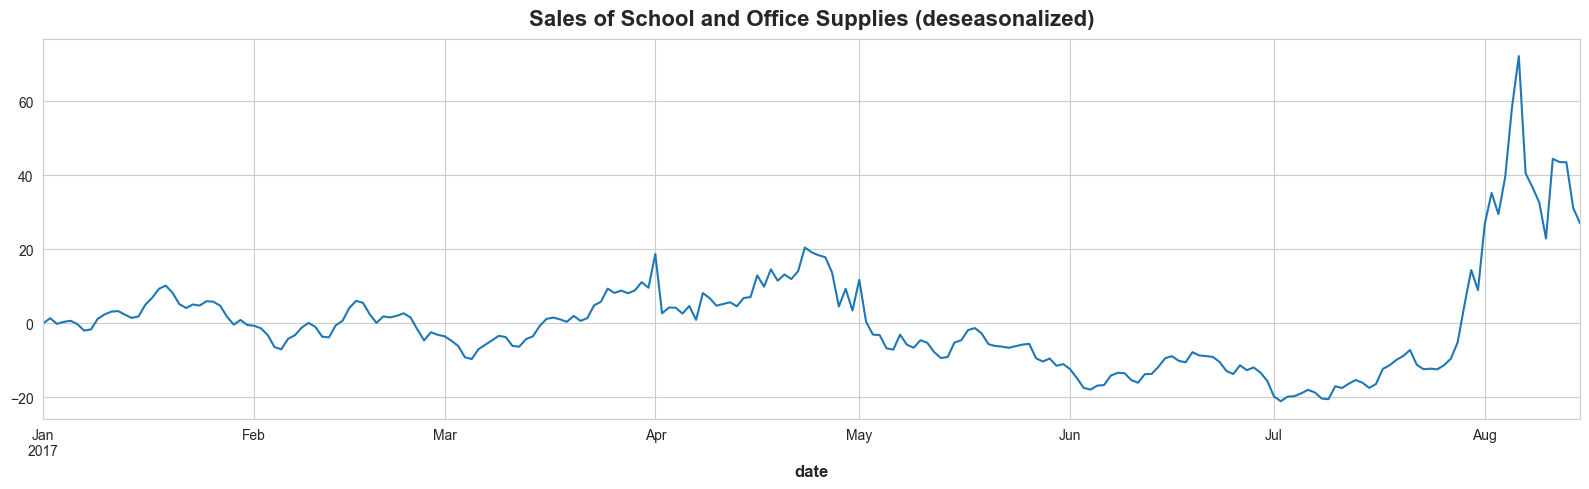

In [128]:
supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y = supply_sales.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(freq='ME', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

fig, ax = plt.subplots(figsize=(16, 5))
ax = y_deseason.plot()
ax.set_title("Sales of School and Office Supplies (deseasonalized)");

To check if this series show cyclic patterns, we apply a moving‑average smoother, long enough to remove short‑term seasonality but short enough to retain cycles.

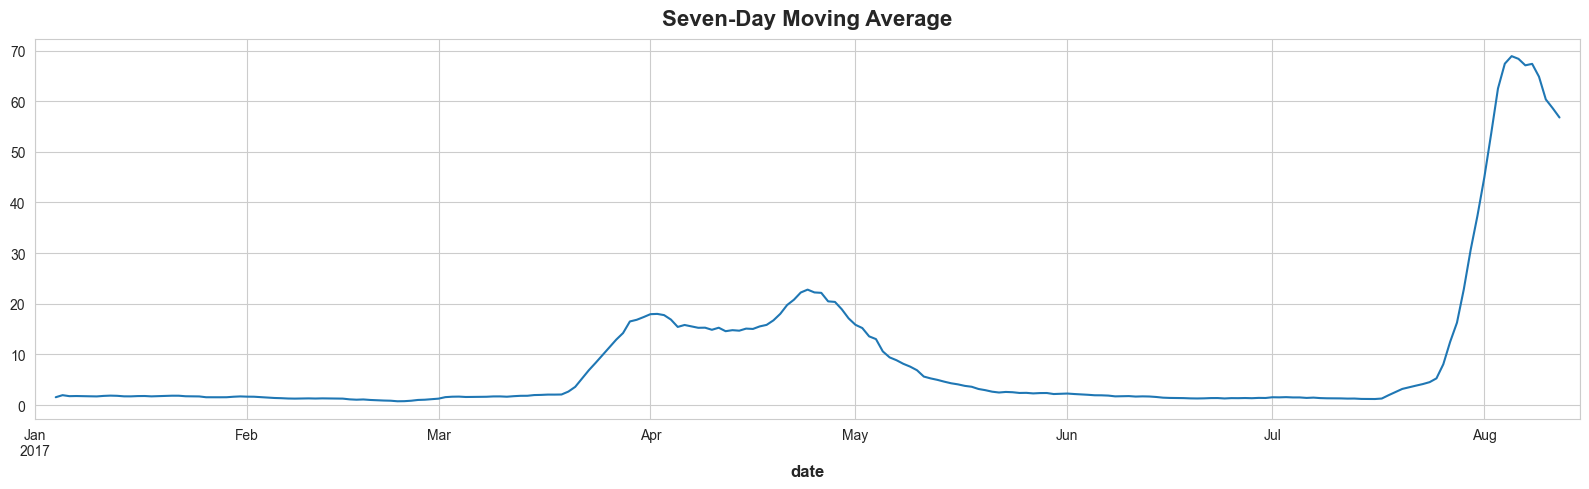

In [129]:
y_ma = y.rolling(window=7, center=True).mean() # 7-day moving average

# Plot
fig, ax = plt.subplots(figsize=(16, 5))
ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average");

In [130]:
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.graphics.tsaplots import plot_pacf


def plot_lags(series=None, *, x=None, y=None, lags=8, leads=0,
              nrows=None, figsize=(10,5), frac=0.3):

    sns.set_style("whitegrid")
    
    # Determine x/y and the shift values to use
    if x is None and y is None:
        x = y = series
        shifts = list(range(1, lags+1))
    else:
        if x is None or y is None:
            raise ValueError("Provide either series alone, or both x and y.")
        
         # Mix of leads (negative shifts) and lags (positive shifts)
        shifts = list(range(-leads, 1)) + list(range(1, lags+1))

    total = len(shifts)
    if nrows is None:
        nrows = 2 if (x is y) else 1
    ncols = int(np.ceil(total / nrows))

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    axes = axes.flatten()

    # Create one plot per lag/lead
    for i, s in enumerate(shifts):
        df = pd.concat([x.shift(s).rename('x'), y.rename('y')], axis=1).dropna()
        ax = axes[i]
        ax.scatter(df.x, df.y, alpha=0.5, s=8)
        sm = lowess(df.y, df.x, frac=frac)
        ax.plot(sm[:,0], sm[:,1], color="red", lw=1.5)
        label = f"{'Lead' if s<0 else 'Lag'} {abs(s)}"
        ax.set_title(label, fontweight="bold", fontsize=9)
        ax.text(0.05, 0.9, f"{df.x.corr(df.y):.2f}",
                transform=ax.transAxes, fontsize=8,
                bbox=dict(facecolor="white", edgecolor="black", pad=0.2))

        row, col = divmod(i, ncols)
        if row == nrows-1:
            ax.set_xlabel(x.name, fontweight="bold", fontsize=8)
        if col == 0:
            ax.set_ylabel(y.name, fontweight="bold", fontsize=8)

    # hide unused axes
    for j in range(total, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    return fig, axes

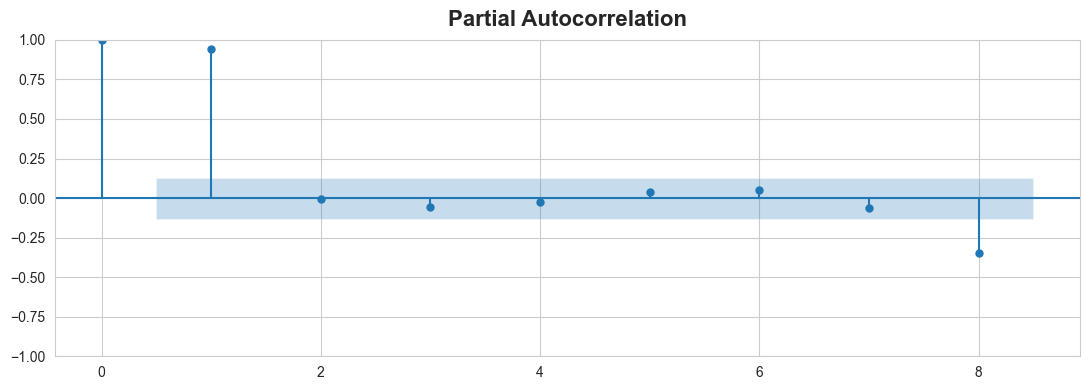

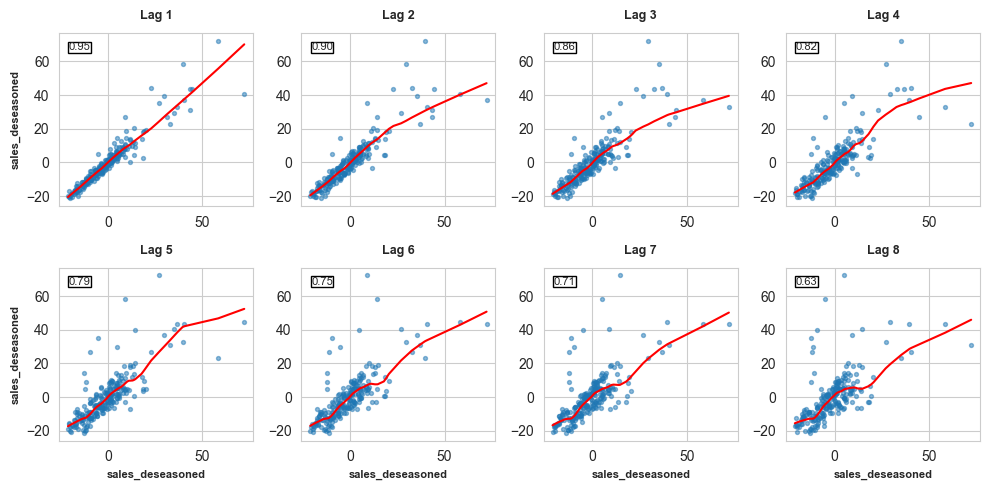

In [131]:
plot_pacf(y_deseason, lags=8)
plot_lags(y_deseason, lags=8);

The correlogram indicates the first lag is likely to be significant, as well as possibly the eighth lag. The lag plot suggests the effect is mostly linear.

In our data, the `onpromotion` series (count of items on special promotion each day) is a natural leading indicator: promotions are decided in advance, so today’s `onpromotion` can help forecast tomorrow’s sales without look‑ahead bias.  


Let's plot `onpromotion` (lagged and leading versions) against deseasonalized sales of school & office supplies to explore its predictive power.  

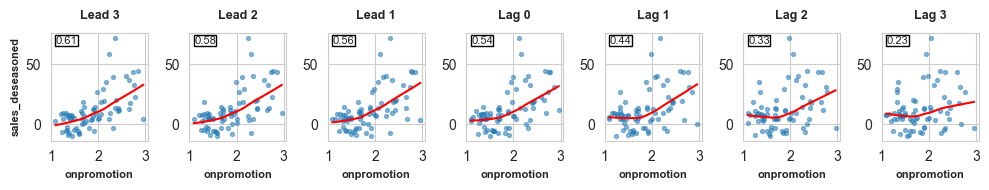

In [132]:
onpromotion = supply_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')
plot_lags(x=onpromotion.loc[onpromotion>1],
          y=y_deseason.loc[onpromotion>1],
          lags=3, leads=3, nrows=1, figsize=(10, 2), frac=0.8);

The lag plot indicates that both leading and lagged values of onpromotion are correlated with supply sales. This suggests that both kinds of values could be useful as features. There may be some non-linear effects as well.

**Time to make these into features!**

In [133]:
import pandas as pd

def make_lags(s: pd.Series, lags: int = 1) -> pd.DataFrame:
    if s.name is None:
        raise ValueError("Series must have a .name")
    return pd.DataFrame({
        f"{s.name}_lag{lag}": s.shift(lag)
        for lag in range(1, lags + 1)
    })


def make_leads(s: pd.Series, leads: int = 1) -> pd.DataFrame:
    if s.name is None:
        raise ValueError("Series must have a .name")
    return pd.DataFrame({
        f"{s.name}_lead{lead}": s.shift(-lead)
        for lead in range(1, leads + 1)
    })


In [134]:
X_lags =  make_lags(y_deseason, lags=1)

X_promo = pd.concat([
    make_lags(onpromotion, lags=1),
    onpromotion,
    make_leads(onpromotion, leads=1),
], axis=1)

X = pd.concat([X_lags, X_promo], axis=1).dropna()
y, X = y.align(X, join='inner')

Training RMSLE: 0.82814
Validation RMSLE: 1.16417


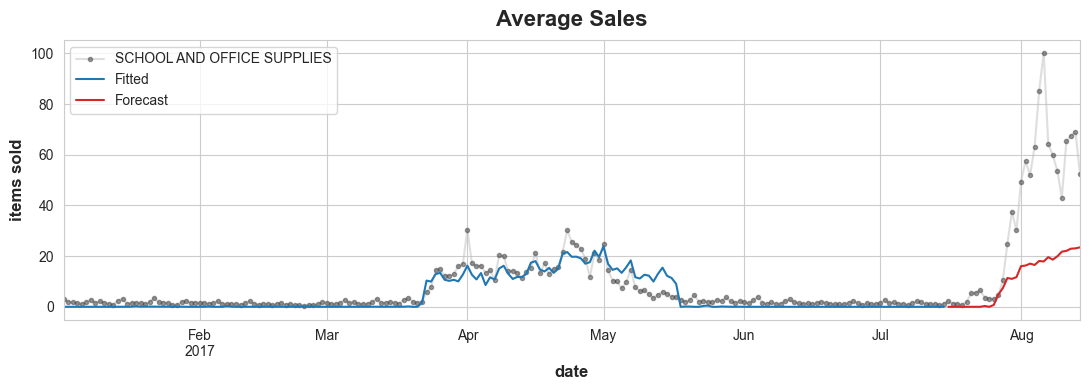

In [142]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

Adding lag and lead features around promotions gave our model extra foresight into demand shifts. Although the August spike still outpaced the forecast, the enhanced model captured a substantial portion of that surge, showing how lags/leads help anticipate sudden jumps.  


---

# 4. Hybrid models

Linear regression can extrapolate trends but doesn't capture interactions well. XGBoost, a tree-based machine learning model, learns complex interactions but cannot extrapolate trends. In this part, we’ll build a hybrid forecaster that uses each model where it performs best.

---

### 4.1 Components and Residuals

A time series can be viewed as an additive sum of:
```
series = trend + seasons + cycles + error
```


- **Components** are trend, seasonal, and cyclical parts.  
- **Residuals** are what remains after subtracting a model’s fit from the actual series.

Iteratively:
1. Fit trend → subtract →  
2. Fit seasonality on residuals → subtract →  
3. Fit cycles on residuals → subtract →  
4. Result: unpredictable error

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/XGJuheO.png" width=700, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Learning the components of <em>Mauna Loa CO2</em> step by step. Subtract the fitted curve (blue) from its series to get the series in the next step.
</center></figcaption>
</figure>

Fitting all features at once (trend, seasonal, cycles) with linear regression yields the same final sum of components.
<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/HZEhuHF.png" width=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Add the learned components to get a complete model.
</center></figcaption>
</figure>

---

### 4.2 Hybrid Forecasting with Residuals

Instead of one algorithm for all components, we can:

1. Fit **Model 1** to original series y → predictions \(ŷ₁\).  
2. Compute residuals \(r = y - ŷ₁\).  
3. Fit **Model 2** to residuals → predictions \(ŷ₂\).  
4. Final forecast = ŷ₁ + ŷ₂.  

Use different feature sets for each model (e.g. trend features for Model 1, interaction features for Model 2).


#### Why Use a Hybrid Approach?

- **Feature-based models** (like linear regression or neural networks) can extrapolate if they're given the right input features.  
- **Target-based models** (like decision trees or k‑nearest neighbors) can't extrapolate trends — they only predict within the range they've seen during training.


<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/ZZtfuFJ.png" width=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center>A decision tree will fail to extrapolate a trend beyond the training set.
</center></figcaption>
</figure>


Hybrid design:  
- Use linear regression to capture and extrapolate trend.  
- Detrend the series.  
- Use XGBoost (or another tree‑based model) on residuals to learn interactions and nonlinear effects.

Let's see how to build an hybrid model using US Retail Sales as an example.

The [*US Retail Sales*](https://www.census.gov/retail/index.html) dataset contains monthly sales data for various retail industries from 1992 to 2019, as collected by the US Census Bureau. Our goal will be to forecast sales in the years 2016-2019 given sales in the earlier years. In addition to creating a linear regression + XGBoost hybrid, we'll also see how to set up a time series dataset for use with XGBoost.

In [98]:
# Set Matplotlib defaults
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

industries = ["BuildingMaterials", "FoodAndBeverage"]
retail = pd.read_csv(
    comp_dir / "us-retail-sales.csv",
    usecols=['Month'] + industries,
    parse_dates=['Month'],
    index_col='Month',
).to_period('D').reindex(columns=industries)
retail = pd.concat({'Sales': retail}, names=[None, 'Industries'], axis=1)

retail.head()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677

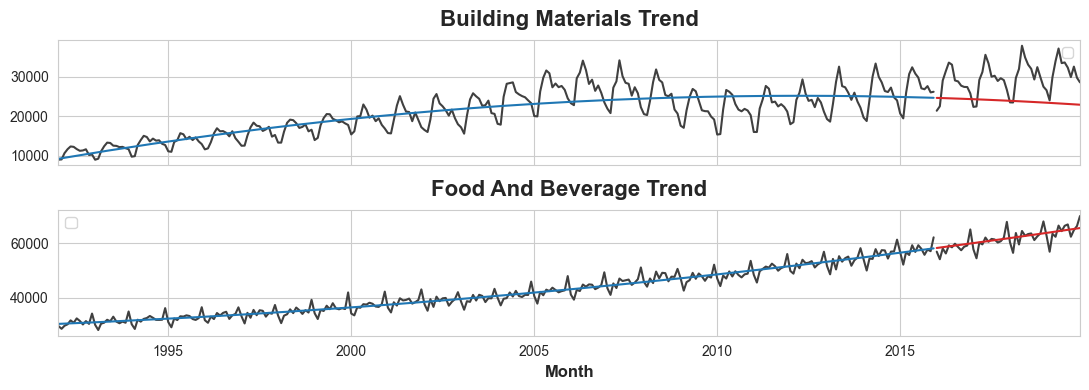

In [99]:

y = retail.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

# Test on the years 2016-2019. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 4, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)

# Remove legends and set individual titles
for i, ax in enumerate(axs):
    ax.legend([])
    if i == 0:
        ax.set_title("Building Materials Trend")
    elif i == 1:
        ax.set_title("Food And Beverage Trend")

Linear regression supports multi-output regression, but XGBoost does not. To predict multiple series with XGBoost, we'll reshape the data from wide to long format, indexing series by category.

In [100]:
from xgboost import XGBRegressor

# The `stack` method converts column labels to row labels, pivoting from wide format to long
X = retail.stack()  # pivot dataset wide to long
display(X.head())
y = X.pop('Sales')  # grab target series

# Turn row labels into categorical feature columns with a label encoding
X = X.reset_index('Industries')
# Label encoding for 'Industries' feature
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

# Label encoding for annual seasonality
X["Month"] = X.index.month  # values are 1, 2, ..., 12

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

Sales
Month      Industries              
1992-01-01 BuildingMaterials   8964
           FoodAndBeverage    29589
1992-02-01 BuildingMaterials   9023
           FoodAndBeverage    28570
1992-03-01 BuildingMaterials  10608

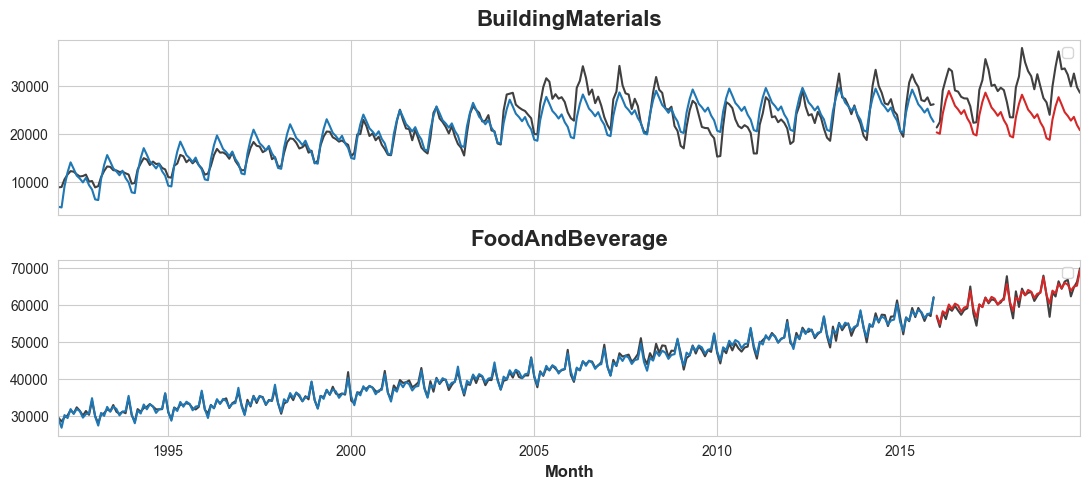

In [101]:

axs = y_train.unstack(['Industries']).plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['BuildingMaterials', 'FoodAndBeverage'],
)
axs = y_test.unstack(['Industries']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack(['Industries']).plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack(['Industries']).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])

The fit appears quite good, though we can see how the trend learned by XGBoost is only as good as the trend learned by the linear regression. In particular, XGBoost wasn't able to compensate for the poorly fit trend in the `'BuildingMaterials'` series.

---

### 4.3 Applying Hybrid model to Retail Sales

In [102]:
comp_dir = Path('Courses data')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

In [103]:
# Create a Boosted hybrid class for training data
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

#### 4.3.1 Define fit method

In [104]:
def fit(self, X_1, X_2, y):

    self.model_1.fit(X_1, y)
    
    y_fit = pd.DataFrame(

        self.model_1.predict(X_1),
        index=X_1.index, columns=y.columns,
    )

    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    self.model_2.fit(X_2, y_resid)

    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit

#### 4.3.2 Define predict method

In [105]:
def predict(self, X_1, X_2):
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1),
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    y_pred += self.model_2.predict(X_2)
    
    return y_pred.unstack()  # long to wide


# Add method to class
BoostedHybrid.predict = predict

#### 4.3.3 Set up the data for training

In [106]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

y = family_sales.loc[:, 'sales']

# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()


# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

#### 4.3.4 Create the Hybrid Model
Using `LinearRegression`() and `XGBRegressor`()

In [107]:
# Create LinearRegression + XGBRegressor hybrid with BoostedHybrid
model = BoostedHybrid(
    LinearRegression(), 
    XGBRegressor())

# Fit the model
model.fit(X_1, X_2, y)
y_pred = model.predict(X_1,X_2)

# clip negative values to zero
y_pred = y_pred.clip(0.0)

Depending on the problem, other hybrid combos might work better than linear regression + XGBoost. Let's try Ridge and KNN:  
- **Ridge** captures smooth global trends while handling multicollinearity.  
- **KNN** captures local patterns and irregularities not explained by the trend.

In [108]:
# Model 1 (trend)
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Boosted Hybrid
model = BoostedHybrid(
    model_1=Ridge(),
    model_2=KNeighborsRegressor(),
)

#### 4.3.5 Check the result

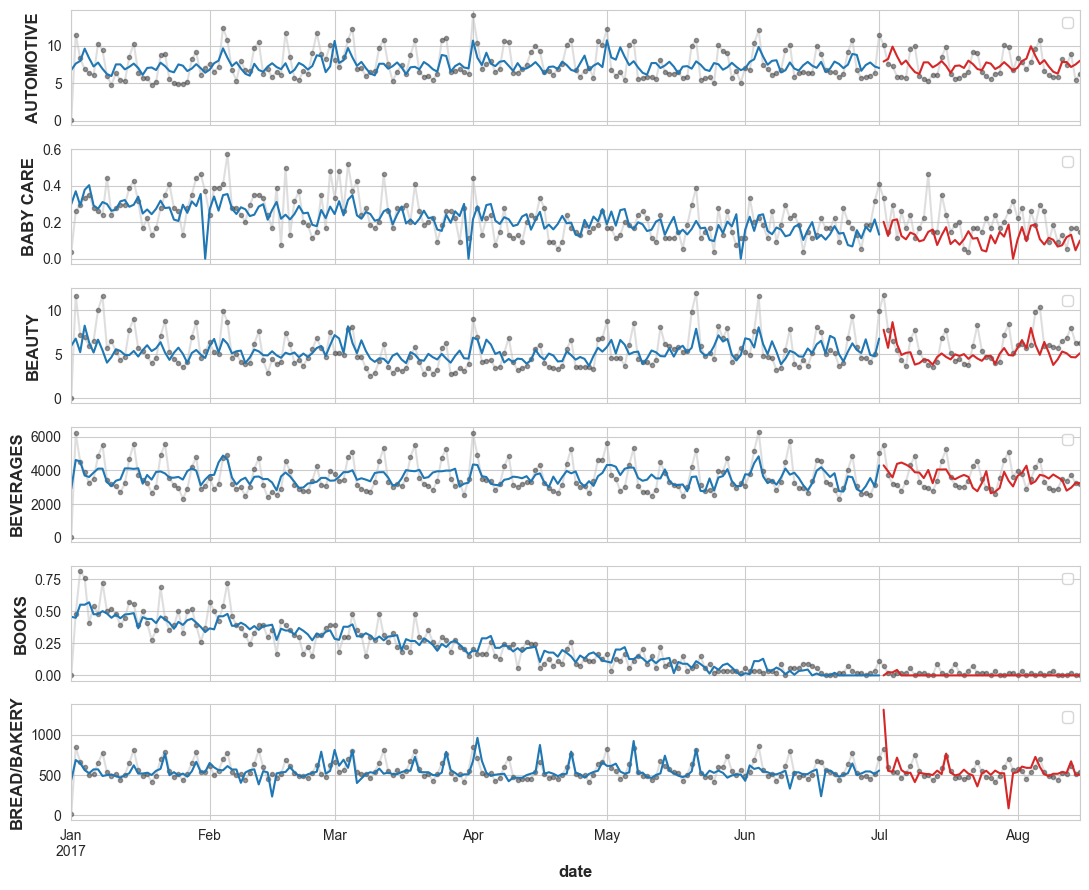

In [112]:
y_train, y_valid = y.loc[:"2017-07-01"], y.loc["2017-07-02":]
X1_train, X1_valid = X_1.loc[:"2017-07-01"], X_1.loc["2017-07-02":] 
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

This hybrid model captures key trends in the training data (blue) with good alignment across product families. The validation forecasts (red) smooth out daily noise but offer a strong baseline, suggesting room for improvement via feature engineering or alternative ensembles.

---

# 5. Forecasting with Lag Features

Previously, we used only trend and seasonality to forecast far into the future. This worked well since those features can be generated from the date itself.

Then we added lag features, which improved accuracy by including past values of the target. But this introduced a new limitation: we could only predict one step ahead unless we had access to future data needed for the lags.

In our earlier setup, we assumed that features like the next 30 days of promotion data were available when predicting the next 30 days of sales. In reality, that's often not the case.

This part focuses on how to handle multistep forecasts when future features aren’t known in advance.

---

### 5.1 Defining the Forecasting Task

Before designing a forecasting model, we need to define two key aspects:

1. **Available Information (Features):** The data available at the time of forecasting.
2. **Required Predictions (Target):** The future period for which we need forecasts.

- The **forecast origin** is the point in time at which the forecast is made, often the last moment with actual data. All data up to the origin can be used to generate features.
- The **forecast horizon** defines the time period we're forecasting for. It’s often described by its length, such as a "1-step" or "5-step" forecast.

![Forecasting Timeline](https://storage.googleapis.com/kaggle-media/learn/images/xwEgcOk.png)
*Figure: A 3-step forecast horizon with a 2-step lead time, using 4 lag features. This represents a single row of training data for a forecast.*

The **lead time** is the time gap between the origin and the start of the forecast horizon. It’s sometimes called *latency*, and may be necessary if there’s a delay in data acquisition.

---

### 5.2 Preparing Data for Forecasting

To apply ML algorithms to time series forecasting, the data needs to be transformed into a format suitable for the models. This process involves:

1. Creating features from lag values
2. Defining the target values (the forecasted values) based on the forecasting task

Each row in a dataframe represents a single forecast. The time index of the row is the first time in the forecast horizon, but we arrange values for the entire horizon in the same row. For multistep forecasts, this means we are requiring a model to produce multiple outputs, one for each step.

In [146]:
N = 20
ts = pd.Series(
    np.arange(N),
    index=pd.period_range(start='2010', freq='A', periods=N, name='Year'),
    dtype=pd.Int8Dtype,
)

# Lag features
X = pd.DataFrame({
    'y_lag_2': ts.shift(2),
    'y_lag_3': ts.shift(3),
    'y_lag_4': ts.shift(4),
    'y_lag_5': ts.shift(5),
    'y_lag_6': ts.shift(6),    
})

# Multistep targets
y = pd.DataFrame({
    'y_step_3': ts.shift(-2),
    'y_step_2': ts.shift(-1),
    'y_step_1': ts,
})

data = pd.concat({'Targets': y, 'Features': X}, axis=1)

data.head(10).style.set_properties(['Targets'], **{'background-color': 'LavenderBlush'}) \
                   .set_properties(['Features'], **{'background-color': 'Lavender'})

The previous section illustrates how a dataset would be prepared for a three-step forecasting task with a two-step lead time using five lag features. The original time series is `y_step_1`, and missing values can either be filled in or dropped.

---


###  5.3 Multistep Forecasting Strategies

There are several strategies for generating the multiple target steps required for a forecast. Here are four common strategies, each with its strengths and weaknesses.

#### Multioutput model

A model that produces multiple outputs naturally. For example, linear regression and neural networks can produce multiple forecasts. This strategy is simple and efficient, but not all algorithms support it (e.g., XGBoost cannot).

![Multioutput Model](https://storage.googleapis.com/kaggle-media/learn/images/uFsHiqr.png)

#### Direct strategy

Train a separate model for each forecast step in the horizon. For example, one model forecasts 1-step ahead, another forecasts 2-steps ahead, and so on. This approach can be more accurate for each step, but it requires training multiple models, which can be computationally expensive.

![Direct Strategy](https://storage.googleapis.com/kaggle-media/learn/images/HkolNMV.png)

#### Recursive strategy

Train a single one-step model and use its forecasts as inputs for the next forecast. We only need to train one model, but since errors will propagate from step to step, forecasts can be inaccurate for long horizons.

![Recursive Strategy](https://storage.googleapis.com/kaggle-media/learn/images/sqkSFDn.png)

#### DirRec strategy

A hybrid of the Direct and Recursive strategies: train a model for each step and use forecasts from previous steps as new lag features. This strategy can capture serial dependence better than Direct, but like Recursive, it suffers from error propagation.

![DirRec Strategy](https://storage.googleapis.com/kaggle-media/learn/images/B7KAvAO.png)

---

### 5.4 Applying Multistep Forecasting to Retail Sales

In [216]:
# Load the data
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
)
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

#### 5.4.1 Identify the forecasting task for *Store Sales* competition

In [217]:
# Get the range of dates for store_sales and test without 'D'
store_sales_range = store_sales.index.get_level_values('date').min().strftime('%Y-%m-%d'), store_sales.index.get_level_values('date').max().strftime('%Y-%m-%d')
test_range = test.index.get_level_values('date').min().strftime('%Y-%m-%d'), test.index.get_level_values('date').max().strftime('%Y-%m-%d')

print("Store Sales Date Range:", store_sales_range)
print("Test Date Range:", test_range)


Store Sales Date Range: ('2013-01-01', '2017-08-15')
Test Date Range: ('2017-08-16', '2017-08-31')


The training set ends on 2017-08-15, which gives us the forecast origin. The test set comprises the dates 2017-08-16 to 2017-08-31, and this gives us the forecast horizon. There is one step between the origin and horizon, so we have a lead time of one day.

Put another way, we need a 16-step forecast with a 1-step lead time. We can use lags starting with lag 1, and we make the entire 16-step forecast using features from 2017-08-15.

#### 5.4.2 Create multistep dataset for *Store Sales*

In [291]:
# Create a function to make lagged features
from typing import Union, List

def make_lags(df: pd.DataFrame, lags: int | list[int]):
    if isinstance(lags, int):
        lags = range(1, lags + 1)

    out = pd.concat({f"lag_{i}": df.shift(i) for i in lags}, axis=1)
    out.columns.names = ["lag", df.columns.name or "family"]
    return out


def make_multistep_target(df: pd.DataFrame, steps: int):

    out = pd.concat({f"y_step_{k}": df.shift(-k)          # ‼ shift ‑k, not ‑(k+1)
                     for k in range(0, steps)}, axis=1)
    out.columns.names = ["step", df.columns.name or "family"]
    return out

y = family_sales.loc[:, 'sales']

# Make 4 lag features
X = make_lags(y, lags=4).dropna()

# Make multistep target
y = make_multistep_target(y, steps=16).dropna()

y, X = y.align(X, join='inner', axis=0)

In [1]:
X

NameError: name 'X' is not defined

In [292]:
le = LabelEncoder()
X = (X
    .stack('family')  # wide to long
    .reset_index('family')  # convert index to column
    .assign(family=lambda x: le.fit_transform(x.family))  # label encode
)
y = y.stack('family')  # wide to long

display(y)

step                                      y_step_0     y_step_1     y_step_2  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     6.333333     6.018518    10.259259   
           BABY CARE                      0.351852     0.277778     0.259259   
           BEAUTY                         5.925926     6.518518    10.037037   
           BEVERAGES                   3258.796387  3507.277832  4848.518555   
           BOOKS                          0.407407     0.537037     0.481481   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      364.955658   403.601349   377.313995   
           PREPARED FOODS                84.698647    87.836800    88.735970   
           PRODUCE                     2257.140625  2609.180176  3122.895752   
           SCHOOL AND OFFICE SUPPLIES    30.111111    49.333332    57.481480   
           SEAFOOD                       20.488333    20.346851    20.801037   

step                                      y_step_3     y_step_4     y_step_5  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     9.388889     5.944445     4.777778   
           BABY CARE                      0.240741     0.444444     0.240741   
           BEAUTY                        11.611111     5.648148     6.500000   
           BEVERAGES                   5503.647949  3448.203613  3171.740723   
           BOOKS                          0.722222     0.500000     0.518519   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      316.436096   533.497009   416.454041   
           PREPARED FOODS                77.172997    91.886765   100.384964   
           PRODUCE                     1792.220947  2079.319336  2418.970215   
           SCHOOL AND OFFICE SUPPLIES    51.907406    63.222221    85.203705   
           SEAFOOD                       17.116297    25.553965    24.209518   

step                                      y_step_6     y_step_7     y_step_8  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     6.314815     5.388889     5.240741   
           BABY CARE                      0.277778     0.296296     0.296296   
           BEAUTY                         5.277778     4.370370     4.703704   
           BEVERAGES                   3046.870361  2693.722168  3226.037109   
           BOOKS                          0.481481     0.388889     0.444444   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      464.596558   344.051758   313.780884   
           PREPARED FOODS               102.248146    86.627441    77.344131   
           PRODUCE                     2675.105957  2111.133301  2168.535400   
           SCHOOL AND OFFICE SUPPLIES   100.277779    64.407410    59.759258   
           SEAFOOD                       23.512852    18.419851    18.481131   

step                                      y_step_9    y_step_10    y_step_11  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     8.500000    10.259259     6.407407   
           BABY CARE                      0.388889     0.425926     0.314815   
           BEAUTY                         7.777778     9.037037     5.648148   
           BEVERAGES                   4667.296387  5580.611328  3700.370361   
           BOOKS                          0.574074     0.555556     0.388889   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      305.270233   278.819885   468.857391   
           PREPARED FOODS                84.796539    78.791443    96.286926   
           PRODUCE                     2663.076416  1670.264893  2198.854492 

#### 5.4.3 Forecast with the DirRec strategy

Now, it's time to make a model combining DirRec strategy with XGBoost.

In [293]:
from sklearn.multioutput import RegressorChain

model = RegressorChain(XGBRegressor())

In [294]:
model.fit(X, y)

y_pred = pd.DataFrame(
    model.predict(X),
    index=y.index,
    columns=y.columns,
).clip(0.0)

In [296]:
from matplotlib.cm import get_cmap

def plot_multistep(y_pred: pd.DataFrame,
                   ax: plt.Axes | None = None,
                   every: int = 16,
                   cmap: str = 'turbo',
                   lw: float = 2.0,
                   alpha: float = 1.0,
                   **kwargs) -> plt.Axes:

    if ax is None:
        _, ax = plt.subplots()

    steps = y_pred.shape[1]
    origins = y_pred.index[::every]
    palette = get_cmap(cmap, len(origins))

    for i, origin in enumerate(origins):
        values = y_pred.loc[origin].values
        # forecast horizon dates
        if isinstance(origin, pd.Period):
            horizon = pd.period_range(origin + 1, periods=steps, freq=origin.freq).to_timestamp()
        else:  # DatetimeIndex
            horizon = origin + pd.to_timedelta(np.arange(1, steps + 1), unit='D')
        ax.plot(horizon, values,
                color=palette(i),
                lw=lw,
                alpha=alpha,
                **kwargs)

    return ax


Now let's visualize the result with the `PRODUCE` family alongside its 16‑step ahead forecasts, plotting one forecast path every 16 days:

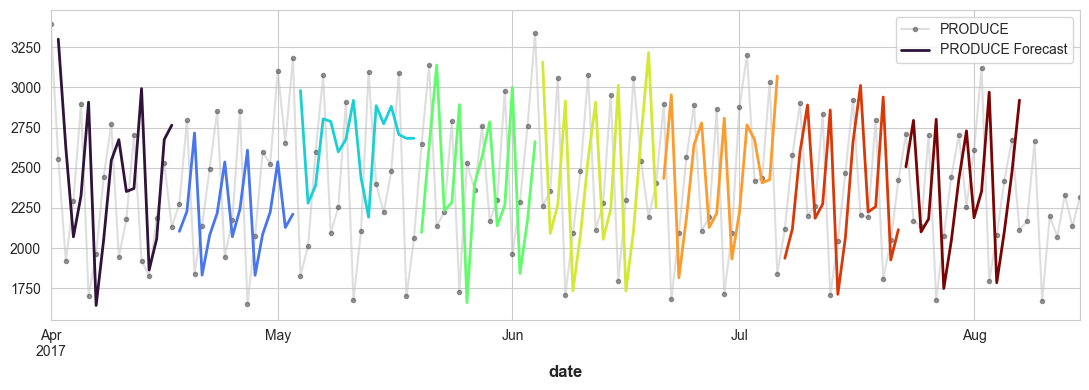

In [304]:
FAMILY = 'PRODUCE'
START = '2017-04-01'
EVERY = 16

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(**plot_params, ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])

The forecast paths appear to follow the actual PRODUCE trends reasonably well, suggesting that the 16-step DirRec XGBoost model may be capturing key patterns and offering decent predictive accuracy.

---

# Conclusion

This notebook walked through a complete and structured approach to time series forecasting, using retail sales data to progressively build better-performing models. Starting with simple trend detection via moving averages and linear regressions, we layered in seasonal patterns with indicator and Fourier features, and finally modeled serial dependence through lagged values and promotion data.

We then explored hybrid strategies, combining the interpretability of linear models with the flexibility of machine learning models like XGBoost. These hybrids effectively captured both global structure and local variations. Finally, we tackled multi-step forecasting using the DirRec strategy, enabling 16-day-ahead predictions across all product families.

While some families showed stronger predictive alignment than others, the overall performance—especially under the DirRec XGBoost setup—suggests that this modeling pipeline is a solid foundation. With further feature engineering, error analysis, and refinement of modeling strategies, it holds strong potential for production-level forecasting tasks.
